In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import Literal,Optional
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
import operator
from langgraph.graph.message import BaseMessage 
#above class is parent class this all AIMessage,HumanMessage,SystemMessage classes is child class inheriting property from parent
#messages will automatically get handle.


#using persistence class to store state or memory value in Ram or Database.
from langgraph.checkpoint.memory import InMemorySaver


checkpointer = InMemorySaver()
checkpointer

load_dotenv()

True

In [2]:
#Groq Model object
model1 = ChatGroq(
    model="groq/compound-mini",
    temperature=0.2
)
model1

#openAI model object.
model2 = ChatOpenAI(temperature=0.2)

## Hugging Face endpoint define karo OPen source Model chat or Generation Model.
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
)

# Chat model object banao
model3 = ChatHuggingFace(llm=llm)

```
Time Travel Using Persistence We Can achieve:-
it help to go backward to nodes and perform execution again help to debbugging it
```

In [3]:
checkpointer = InMemorySaver()
checkpointer

class JokeState(TypedDict):
    title : str
    gen_joke : str | None
    gen_expl : str | None
    
#creating an object of stategraph class.
graph = StateGraph(JokeState)
graph

In [4]:
#creating Generate_Joke node ke liye function.
def Generate_Joke(state:JokeState) ->JokeState:
    
    parser = StrOutputParser()
    
    #fetching the topic from state class
    topic = state['title']
    
    #creating a prompt template or structure instruction based on this topic.
    prompt = PromptTemplate(
        template="""
        You are an expert joke generator.  
        Your task is to create a **funny joke** based strictly on the given topic: "{topic}".

        Instructions:
        1. Make the joke humorous, witty, and short (2-3 sentences max).  
        2. Do not add anything extra outside the joke.  
        3. The joke should be original and not copied.  
        
        """,
        input_variables=['topic']
        
    )
    
    #passing the prompt to model. using sequential chain
    chain = prompt | model1 | parser
    
    #invoking the chain.
    result = chain.invoke({'topic':topic})
    
    #now updating the state the partial stae and returning back.
    return {
        'gen_joke':result
    }
    

In [5]:
#creating Generate_Explanation node ke liye function.
def Generate_Explanation(state:JokeState) ->JokeState:
    
    parser = StrOutputParser()
    
    #fetching the topic from state class
    topic = state['title']
    joke = state['gen_joke']
    
    #creating a prompt template or structure instruction based on this topic.
    prompt = PromptTemplate(
        template="""
        You are an expert joke explanation.  
        Your task is to provide Explantion of  **funny joke** based on the given Joke topic: "{joke}".

        Instructions:
        1. Make the Explanation of Joke to be short (2-3 sentences max).  
        2. The Explanation should be original and not copied.  
        
        """,
        input_variables=['joke']
        
    )
    
    #passing the prompt to model. using sequential chain
    chain = prompt | model1 | parser
    
    #invoking the chain.
    result = chain.invoke({'joke':joke})
    
    #now updating the state the partial stae and returning back.
    return {
        'gen_expl':result
    }
    

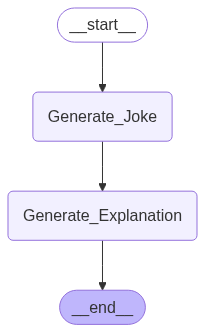

In [6]:
#adding the node to graph.
graph.add_node(node="Generate_Joke",action=Generate_Joke)
graph.add_node(node="Generate_Explanation",action=Generate_Explanation)



#adding edges to graph
graph.add_edge(START,'Generate_Joke')
graph.add_edge('Generate_Joke','Generate_Explanation')
graph.add_edge('Generate_Explanation',END)

#compiling the graph.
graph.compile()

In [7]:
workflow = graph.compile(checkpointer=checkpointer)

#calling the initial state by creating an object of that class.
initial_state = JokeState(title="pizza")


#now invoking the workflow passing the inital state throughout workflow.
result = workflow.invoke(input=initial_state,config={"configurable": {"thread_id": "1"}})
result

{'title': 'pizza',
 'gen_joke': "Why did the pizza go to therapy? It had a saucy attitude and a crusty exterior that was hiding a cheesy insecurity. Now it's working on a topping complex.",
 'gen_expl': 'This joke plays on the multiple meanings of pizza-related terms to create a humorous therapy session scenario. The "saucy attitude" and "crusty exterior" are puns on the pizza\'s physical characteristics, while also describing a person\'s defensive personality traits. The punchline about a "topping complex" cleverly ties the pizza theme to psychological jargon, implying the pizza (or person) is working on overcoming feelings of inadequacy.'}

In [8]:
# to show starting or intermediate and ending nodes state value
list(workflow.get_state_history(config={"configurable": {"thread_id": "1"}}))

[StateSnapshot(values={'title': 'pizza', 'gen_joke': "Why did the pizza go to therapy? It had a saucy attitude and a crusty exterior that was hiding a cheesy insecurity. Now it's working on a topping complex.", 'gen_expl': 'This joke plays on the multiple meanings of pizza-related terms to create a humorous therapy session scenario. The "saucy attitude" and "crusty exterior" are puns on the pizza\'s physical characteristics, while also describing a person\'s defensive personality traits. The punchline about a "topping complex" cleverly ties the pizza theme to psychological jargon, implying the pizza (or person) is working on overcoming feelings of inadequacy.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-68db-668a-8002-f5805a311354'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-06T11:00:34.696359+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b1

# Time Travel

# these is the way to go back to any node in WORKFLOW (cut mara hu)

In [10]:
#these is the way to go back to any node in WORKFLOW
workflow.get_state(config={
    'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-5bff-61c0-8000-b0c68920562a'}}
                   )

StateSnapshot(values={'title': 'pizza'}, next=('Generate_Joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-5bff-61c0-8000-b0c68920562a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-06T11:00:33.347833+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-5bfc-6ab8-bfff-d756dadc2cd1'}}, tasks=(PregelTask(id='48b936aa-f091-71b3-30a8-9745caef7bce', name='Generate_Joke', path=('__pregel_pull', 'Generate_Joke'), error=None, interrupts=(), state=None, result={'gen_joke': "Why did the pizza go to therapy? It had a saucy attitude and a crusty exterior that was hiding a cheesy insecurity. Now it's working on a topping complex."}),), interrupts=())

# after going back to paticular node agar mujhe that node se workflow execution wapas start or resume karni hai toh you will see the difference in state history

In [ ]:
workflow.invoke(input=None,
                config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-5bff-61c0-8000-b0c68920562a'}}
                )
# same topic se meine explanation dusra liya hu

{'title': 'pizza',
 'gen_joke': "Why did the pizza go to therapy? It had a saucy attitude and a crusty personality. Now it's working on its toppings complex.",
 'gen_expl': 'This joke plays on the multiple meanings of pizza-related terms to create a punny therapy scenario. The phrase "saucy attitude" and "crusty personality" are wordplays on common pizza characteristics, implying the pizza has a cheeky and tough demeanor. The punchline about the "toppings complex" cleverly references both a psychological complex and the pizza toppings, adding a layer of cleverness to the joke.'}

# to show saarey intermediate workow ke andar state value

In [12]:
list(workflow.get_state_history(config={"configurable": {"thread_id": "1"}})) #top 2 will come with time travel ki vajey se

[StateSnapshot(values={'title': 'pizza', 'gen_joke': "Why did the pizza go to therapy? It had a saucy attitude and a crusty personality. Now it's working on its toppings complex.", 'gen_expl': 'This joke plays on the multiple meanings of pizza-related terms to create a punny therapy scenario. The phrase "saucy attitude" and "crusty personality" are wordplays on common pizza characteristics, implying the pizza has a cheeky and tough demeanor. The punchline about the "toppings complex" cleverly references both a psychological complex and the pizza toppings, adding a layer of cleverness to the joke.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10f-b9d1-69b3-8002-6282a36b18bb'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-06T11:02:30.559992+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10f-b283-69a1-8001-00d21162cb1f'}}, tasks=(), interrupts=()),
 St

# we can go backward to paticular checkpoint of node and do update in state

# #update state#

In [19]:
#meine jab topic provide hone ke baad ----> gen_joke level ke checkpoint pe gaya hu to update topic
workflow.update_state(config=
                      {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-5bff-61c0-8000-b0c68920562a'}}
                      ,
                      values={'title':'sex'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08b11f-a7b3-61cc-8001-7873a4d54036'}}

In [20]:
list(workflow.get_state_history(config={"configurable": {"thread_id": "1"}}))

[StateSnapshot(values={'title': 'sex'}, next=('Generate_Joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b11f-a7b3-61cc-8001-7873a4d54036'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-09-06T11:09:38.156794+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b10b-5bff-61c0-8000-b0c68920562a'}}, tasks=(PregelTask(id='e984123d-47ad-90e9-b944-9ce5baad7478', name='Generate_Joke', path=('__pregel_pull', 'Generate_Joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'title': 'pizza'}, next=('Generate_Joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b11c-592f-6c54-8001-165eee154da4'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-09-06T11:08:09.393467+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '

In [21]:
#executing the state again
workflow.invoke(input=None,config={
  'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b11f-a7b3-61cc-8001-7873a4d54036'}})

{'title': 'sex',
 'gen_joke': 'Why did sex go to therapy? Because it was struggling to connect with people and was feeling a little "dysfunctional". Now it\'s working on building intimacy issues.',
 'gen_expl': 'This joke plays on the double meanings of words related to intimacy and psychological issues. The phrase "struggling to connect with people" and "dysfunctional" have literal and figurative meanings in the context of relationships and sex, while also being common issues addressed in therapy. The punchline about "building intimacy issues" is a clever twist, as it references both the therapeutic goal and a common problem in relationships, adding a layer of irony to the humor.'}

In [22]:
# to show every checkpoint level pe state value.
list(workflow.get_state_history(config={"configurable": {"thread_id": "1"}}))

[StateSnapshot(values={'title': 'sex', 'gen_joke': 'Why did sex go to therapy? Because it was struggling to connect with people and was feeling a little "dysfunctional". Now it\'s working on building intimacy issues.', 'gen_expl': 'This joke plays on the double meanings of words related to intimacy and psychological issues. The phrase "struggling to connect with people" and "dysfunctional" have literal and figurative meanings in the context of relationships and sex, while also being common issues addressed in therapy. The punchline about "building intimacy issues" is a clever twist, as it references both the therapeutic goal and a common problem in relationships, adding a layer of irony to the humor.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b121-4296-6633-8003-d87cd8b211f6'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-09-06T11:10:21.241502+00:00', parent_config={'configurable': {'thread_id': '1', 'ch